In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import f1_score,precision_score
from torch.amp import GradScaler, autocast
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
def calculate_dice(y_true, y_pred, threshold=0.5):
    """
    Calcula el coeficiente de Dice entre las predicciones y las etiquetas reales.
    
    Args:
        y_true (torch.Tensor): Tensor de etiquetas reales.
        y_pred (torch.Tensor): Tensor de predicciones del modelo.
        threshold (float): Umbral para binarizar las predicciones.
        
    Returns:
        float: Valor promedio de Dice.
    """
    y_pred = (y_pred > threshold).float()  # Binarizar predicciones
    intersection = (y_true * y_pred).sum(dim=(1, 2, 3))
    dice = (2 * intersection + 1e-6) / (y_true.sum(dim=(1, 2, 3)) + y_pred.sum(dim=(1, 2, 3)) + 1e-6)
    return dice.mean().item()
def load_model(model_class, checkpoint_path, device=DEVICE):
    """
    Carga un modelo a partir de un archivo de checkpoint.

    Args:
        model_class (torch.nn.Module): Clase del modelo a instanciar (e.g., UNet).
        checkpoint_path (str): Ruta al archivo del checkpoint con los pesos del modelo.
        device (torch.device): Dispositivo en el que se cargará el modelo.

    Returns:
        torch.nn.Module: Modelo cargado con los pesos.
    """
    model = model_class().to(device)  # Instanciar el modelo
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))  # Cargar los pesos
    model.eval()  # Establecer en modo de evaluación
    return model
def visualize_predictions(model, data_loader, num_samples=3, threshold=0.01):
    """
    Visualiza las imágenes, etiquetas reales y predicciones del modelo.
    
    Args:
        model (torch.nn.Module): Modelo entrenado.
        data_loader (DataLoader): DataLoader con las imágenes y etiquetas.
        num_samples (int): Número de muestras a visualizar.
        threshold (float): Umbral para binarizar las predicciones.
    """
    model.eval()
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    
    for i, (image, label) in enumerate(data_loader):
        if i >= num_samples:
            break
        
        with torch.no_grad():
            pred = torch.sigmoid(model(image.to(DEVICE))).cpu()  # Aplicar Sigmoid
            pred = (pred > threshold).float()  # Binarizar las predicciones

        # Convertir tensores a arrays NumPy
        image_np = image[0].squeeze().cpu().numpy()
        label_np = label[0].squeeze().cpu().numpy()
        pred_np = pred[0].squeeze().cpu().numpy()

        # Mostrar imágenes, etiquetas y predicciones
        axes[i, 0].imshow(image_np, cmap='gray')
        axes[i, 0].set_title('Input Image')
        axes[i, 1].imshow(label_np, cmap='gray')
        axes[i, 1].set_title('Ground Truth')
        axes[i, 2].imshow(pred_np, cmap='gray')
        axes[i, 2].set_title('Prediction')
    
    plt.tight_layout()
    plt.show()
    
def find_optimal_threshold(model, val_dataloader, thresholds=np.linspace(0.01, 0.9, 50)):
    """
    Encuentra el umbral óptimo basado en el coeficiente de Dice.
    """
    best_threshold = 0.5
    best_dice = 0.0
 
    model.eval()
    with torch.no_grad():
        for threshold in thresholds:
            dice_scores = []
            for vinputs, vtargets in val_dataloader:
                vinputs, vtargets = vinputs.to(DEVICE), vtargets.to(DEVICE)
                voutputs = torch.sigmoid(model(vinputs))
                dice = calculate_dice(vtargets, voutputs, threshold)
                dice_scores.append(dice)
            
            avg_dice = sum(dice_scores) / len(dice_scores)
            if avg_dice > best_dice:
                best_dice = avg_dice
                best_threshold = threshold
    
    print(f"Optimal threshold: {best_threshold} with Dice: {best_dice:.4f}")
    return best_threshold
def calculate_metrics(y_true, y_pred, threshold=0.5):
    """
    Calcula varias métricas en porcentaje para evaluar el modelo.
    
    Args:
        y_true (torch.Tensor): Tensor de etiquetas reales.
        y_pred (torch.Tensor): Tensor de predicciones del modelo.
        threshold (float): Umbral para binarizar las predicciones.
    
    Returns:
        dict: Diccionario con las métricas en porcentaje.
    """
    y_pred = (y_pred > threshold).float()  # Binarizar predicciones
    y_true = y_true.float()  # Asegurar que las etiquetas sean float

    # Calcular métricas básicas
    TP = (y_pred * y_true).sum().item()  # Verdaderos positivos
    FP = (y_pred * (1 - y_true)).sum().item()  # Falsos positivos
    FN = ((1 - y_pred) * y_true).sum().item()  # Falsos negativos
    TN = ((1 - y_pred) * (1 - y_true)).sum().item()  # Verdaderos negativos

    # Evitar divisiones por 0
    epsilon = 1e-6

    # Métricas
    accuracy = ((TP + TN) / (TP + TN + FP + FN + epsilon)) * 100
    precision = (TP / (TP + FP + epsilon)) * 100
    recall = (TP / (TP + FN + epsilon)) * 100
    f1 = (2 * precision * recall / (precision + recall + epsilon))
    iou = (TP / (TP + FP + FN + epsilon)) * 100

    return {
        "Accuracy (%)": accuracy,
        "Precision (%)": precision,
        "Recall (%)": recall,
        "F1-Score (%)": f1,
        "IoU (%)": iou
    }
def evaluate_model(model, test_loader, threshold=0.5):
    """
    Evalúa el modelo en el conjunto de prueba y calcula métricas promedio.
    
    Args:
        model (torch.nn.Module): Modelo entrenado.
        test_loader (DataLoader): DataLoader del conjunto de prueba.
        threshold (float): Umbral para binarizar las predicciones.
    
    Returns:
        dict: Diccionario con las métricas promedio en porcentaje.
    """
    model.eval()
    all_metrics = {
        "Accuracy (%)": [],
        "Precision (%)": [],
        "Recall (%)": [],
        "F1-Score (%)": [],
        "IoU (%)": []
    }

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = torch.sigmoid(model(images))  # Aplicar Sigmoid

            # Calcular métricas para cada batch
            metrics = calculate_metrics(labels, outputs, threshold)
            for key in all_metrics:
                all_metrics[key].append(metrics[key])

    # Promediar las métricas
    averaged_metrics = {key: np.mean(values) for key, values in all_metrics.items()}
    return averaged_metrics
def evaluate_multiple_models(models, test_loader, thresholds, device=DEVICE):
    """
    Evalúa múltiples modelos en el conjunto de prueba y compara su rendimiento.
    
    Args:
        models (list): Lista de modelos entrenados.
        test_loader (DataLoader): DataLoader del conjunto de prueba.
        thresholds (list): Lista de umbrales para binarizar las predicciones.
        device (torch.device): Dispositivo en el que se ejecutarán los modelos.
    
    Returns:
        dict: Diccionario con los resultados de cada modelo.
    """
    results = {}

    for i, model in enumerate(models):
        print(f"Evaluando Modelo {i+1}...")
        model.eval()
        model.to(device)

        metrics_by_threshold = {th: {"Accuracy (%)": [], "Precision (%)": [], "Recall (%)": [], "F1-Score (%)": [], "IoU (%)": []} for th in thresholds}

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = torch.sigmoid(model(images))  # Aplicar Sigmoid para obtener predicciones entre 0 y 1

                for th in thresholds:
                    # Calcular métricas para cada umbral
                    metrics = calculate_metrics(labels, outputs, threshold=th)
                    for key in metrics_by_threshold[th]:
                        metrics_by_threshold[th][key].append(metrics[key])

        # Promediar las métricas para cada umbral
        averaged_metrics = {}
        for th, metrics in metrics_by_threshold.items():
            averaged_metrics[th] = {key: np.mean(values) for key, values in metrics.items()}

        # Guardar los resultados del modelo
        results[f"Modelo {i+1}"] = averaged_metrics

    return results
import matplotlib.pyplot as plt

def compare_iou_dice(models, test_loader, thresholds, device=DEVICE):
    """
    Compara gráficamente el rendimiento de múltiples modelos en términos de IoU y Dice.

    Args:
        models (list): Lista de modelos entrenados.
        test_loader (DataLoader): DataLoader con las imágenes y etiquetas del conjunto de prueba.
        thresholds (list): Lista de umbrales para binarizar las predicciones.
        device (torch.device): Dispositivo en el que se ejecutarán los modelos.
    """
    iou_scores = {f"Modelo {i+1}": [] for i in range(len(models))}
    dice_scores = {f"Modelo {i+1}": [] for i in range(len(models))}

    for i, model in enumerate(models):
        model.eval()
        model.to(device)

        for threshold in thresholds:
            iou_list = []
            dice_list = []

            with torch.no_grad():
                for images, labels in test_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = torch.sigmoid(model(images))

                    # Calcular IoU y Dice
                    metrics = calculate_metrics(labels, outputs, threshold)
                    iou_list.append(metrics["IoU (%)"])
                    dice_list.append(calculate_dice(labels, outputs, threshold) * 100)  # Convertimos Dice a porcentaje

            # Promediar las métricas para este umbral
            iou_scores[f"Modelo {i+1}"].append(np.mean(iou_list))
            dice_scores[f"Modelo {i+1}"].append(np.mean(dice_list))

    # Crear gráficos comparativos
    plt.figure(figsize=(12, 6))

    for model_name, iou in iou_scores.items():
        plt.plot(thresholds, iou, marker='o', label=f"{model_name} (IoU)")

    for model_name, dice in dice_scores.items():
        plt.plot(thresholds, dice, marker='x', linestyle='--', label=f"{model_name} (Dice)")

    plt.title("Comparación de IoU y Dice para Múltiples Modelos")
    plt.xlabel("Umbral de Predicción")
    plt.ylabel("Porcentaje (%)")
    plt.legend()
    plt.grid()
    plt.show()




In [3]:
def draw_error_boxes_from_bitmap(image, bitmap, box_thickness=10, margin=20):
    """
    Dibuja un único rectángulo que engloba todas las áreas con errores detectados, 
    ampliando el contorno con un margen adicional si se especifica.

    Args:
        image (torch.Tensor): Imagen original (formato tensor o array numpy).
        bitmap (torch.Tensor): Mapa binario de píxeles detectados como errores.
        box_thickness (int): Grosor del rectángulo dibujado.
        margin (int): Margen adicional alrededor del rectángulo.

    Returns:
        np.ndarray: Imagen original con el rectángulo dibujado.
    """
    # Convertir tensores a numpy si es necesario
    if isinstance(image, torch.Tensor):
        image = image.squeeze().cpu().numpy()
    if isinstance(bitmap, torch.Tensor):
        bitmap = bitmap.squeeze().cpu().numpy()

    # Asegurarse de que el bitmap es binario (0 o 1)
    bitmap = bitmap.astype(np.uint8)

    # Encontrar contornos en el mapa binario
    contours, _ = cv2.findContours(bitmap, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Convertir la imagen original a formato RGB para dibujar en color
    image_bgr = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)

    if contours:
        # Combinar todos los contornos en un solo rectángulo envolvente
        all_points = np.vstack(contours)  # Combinar todos los puntos de los contornos
        x, y, w, h = cv2.boundingRect(all_points)  # Crear un rectángulo que englobe todos los puntos

        # Ampliar el rectángulo con el margen especificado
        x = max(x - margin, 0)
        y = max(y - margin, 0)
        w += 2 * margin
        h += 2 * margin

        # Dibujar el rectángulo ampliado (color rojo)
        cv2.rectangle(image_bgr, (x, y), (x + w, y + h), (255, 0, 0), box_thickness)

    return image_bgr
def postprocess_bitmap(bitmap, kernel_size=3):
    """
    Aplica operaciones de cierre y apertura para refinar un mapa de bits.

    Args:
        bitmap (np.ndarray): Mapa binario (numpy array) generado por el modelo.
        kernel_size (int): Tamaño del kernel para las operaciones morfológicas.

    Returns:
        np.ndarray: Mapa de bits refinado.
    """
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Operación de cierre (rellena huecos pequeños)
    closed = cv2.morphologyEx(bitmap, cv2.MORPH_CLOSE, kernel)

    # Operación de apertura (elimina ruido pequeño)
    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)

    return opened
def filter_and_visualize_errors_from_bitmap_post(
    model, data_loader, pixel_threshold=50, pred_threshold=0.5, kernel_size=3, num_bad_samples=5
):
    """
    Filtra y visualiza imágenes con predicciones (buenas y malas), etiquetando cada una
    y mostrando hasta que se alcancen un número determinado de piezas malas.

    Args:
        model (torch.nn.Module): Modelo entrenado.
        data_loader (DataLoader): DataLoader con las imágenes y etiquetas.
        pixel_threshold (int): Umbral mínimo de píxeles predichos como errores para considerar una pieza mala.
        pred_threshold (float): Umbral para binarizar las predicciones del modelo.
        kernel_size (int): Tamaño del kernel para las operaciones morfológicas.
        num_bad_samples (int): Número máximo de piezas malas a visualizar.
    """
    model.eval()
    total_samples = 0  # Contador total de imágenes mostradas
    bad_samples = 0  # Contador de piezas malas

    # Preparar la figura para visualizar los resultados
    fig, axes = plt.subplots(num_bad_samples * 2, 4, figsize=(25, 7 * num_bad_samples * 2))

    for image, label in data_loader:
        if bad_samples >= num_bad_samples:
            break

        with torch.no_grad():
            # Generar predicciones
            pred = torch.sigmoid(model(image.to(DEVICE))).cpu().numpy()  # Aplicar Sigmoid
            binary_pred = (pred > pred_threshold).astype(np.uint8)  # Binarizar las predicciones

            # Refinar mapas de bits
            refined_preds = np.array([
                postprocess_bitmap(bitmap[0], kernel_size=kernel_size) for bitmap in binary_pred
            ])

            # Calcular el número de píxeles predichos como defectuosos en el mapa refinado
            pixel_sum = refined_preds.sum(axis=(1, 2))

        # Procesar cada predicción y clasificar como buena o mala
        for i, pixel_count in enumerate(pixel_sum):
            if bad_samples >= num_bad_samples:
                break

            # Determinar si la pieza es buena o mala
            is_bad = pixel_count > pixel_threshold
            label_text = "Mala" if is_bad else "Buena"

            if not is_bad:
                # Mostrar la imagen original y el mapa refinado sin dibujar el recuadro
                image_with_boxes = image[i].squeeze().cpu().numpy()
            else:
                # Dibujar los errores sobre la imagen original basándose en el mapa de bits refinado
                image_with_boxes = draw_error_boxes_from_bitmap(image[i], refined_preds[i])

            # Mostrar la imagen original, el mapa refinado, los errores detectados y la etiqueta real
            axes[total_samples, 0].imshow(image[i].squeeze().cpu().numpy(), cmap='gray')
            axes[total_samples, 0].set_title(f"Imagen Original\n(Píxeles Erróneos: {int(pixel_count)})")
            
            axes[total_samples, 1].imshow(label[i].squeeze().cpu().numpy(), cmap='gray')
            axes[total_samples, 1].set_title("Etiqueta Real")

            axes[total_samples, 2].imshow(refined_preds[i], cmap='gray')
            axes[total_samples, 2].set_title("Mapa Refinado (Errores)")

            axes[total_samples, 3].imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB) if not is_bad else image_with_boxes, cmap='gray')
            axes[total_samples, 3].set_title(f"Errores Detectados\n(Pieza: {label_text})")



            total_samples += 1

            # Incrementar el contador de piezas malas si corresponde
            if is_bad:
                bad_samples += 1

    plt.tight_layout()
    plt.show()



In [4]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        self.bottleneck = self.conv_block(512, 1024)

        self.up4 = self.upconv(1024, 512)
        self.dec4 = self.conv_block(1024, 512)
        self.up3 = self.upconv(512, 256)
        self.dec3 = self.conv_block(512, 256)
        self.up2 = self.upconv(256, 128)
        self.dec2 = self.conv_block(256, 128)
        self.up1 = self.upconv(128, 64)
        self.dec1 = self.conv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def upconv(self, in_channels, out_channels):
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, 2))
        enc3 = self.enc3(F.max_pool2d(enc2, 2))
        enc4 = self.enc4(F.max_pool2d(enc3, 2))

        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2))

        dec4 = self.up4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)
        dec3 = self.up3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)
        dec2 = self.up2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)
        dec1 = self.up1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)

        return self.final(dec1)

In [5]:
def load_dataset(root_dir):
    """
    Carga todas las imágenes y etiquetas desde una carpeta raíz con múltiples subcarpetas.

    Args:
        root_dir (str): Ruta de la carpeta raíz que contiene las carpetas kosXX.

    Returns:
        images (list): Lista de arrays de imágenes.
        labels (list): Lista de arrays de mapas de defectos.
    """
    images = []
    labels = []
    images_augmented = []
    labels_augmented = []
    # Iterar por cada carpeta (e.g., kos01, kos02, ...)
    for folder in sorted(os.listdir(root_dir)):
        folder_path = os.path.join(root_dir, folder)

        if os.path.isdir(folder_path):  # Asegurarse de que sea una carpeta
            # Iterar por cada archivo en la carpeta
            for file in sorted(os.listdir(folder_path)):
                file_path = os.path.join(folder_path, file)

                # Cargar imágenes y etiquetas
                if file.endswith(".jpg"):  # Es una imagen
                    if file.endswith(("aug_0.jpg", "aug_1.jpg", "aug_2.jpg", "aug_3.jpg", "aug_4.jpg", "aug_5.jpg", "aug_6.jpg")):
                        img = Image.open(file_path).convert("L")  # Convertir a escala de grises
                        images_augmented.append(np.array(img))  # Convertir a array NumPy
                    else:
                        img = Image.open(file_path).convert("L")  # Convertir a escala de grises
                        images.append(np.array(img))  # Convertir a array NumPy
                elif file.endswith(".bmp"):  # Es un mapa de etiquetas
                    if file.endswith(("aug_0_label.bmp", "aug_1_label.bmp", "aug_2_label.bmp", "aug_3_label.bmp", "aug_4_label.bmp", "aug_5_label.bmp", "aug_6_label.bmp")):
                        label = Image.open(file_path).convert("L")  # Convertir a escala de grises
                        labels_augmented.append(np.array(label)) 
                    else:
                        label = Image.open(file_path).convert("L")  # Convertir a escala de grises
                        labels.append(np.array(label))  # Convertir a array NumPy

    return images, labels, images_augmented, labels_augmented
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None, label_transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.label_transform = label_transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Convertir las imágenes y etiquetas de NumPy a PIL
        image = Image.fromarray(self.images[idx])
        label = Image.fromarray(self.labels[idx])

        # Aplicar transformaciones
        if self.transform:
            image = self.transform(image)
        if self.label_transform:
            label = self.label_transform(label)

        return image, label
transform = transforms.Compose([
    transforms.Resize((1024, 512)),
    transforms.ToTensor(),  # Convertir a tensor
])

# Transformaciones para las etiquetas
label_transform = transforms.Compose([
    transforms.Resize((1024, 512)),
    transforms.ToTensor(),  # Convertir a tensor
])
root_dir = r"C:\Users\jerij\Carpetas\Clases Formaciones Curro\Master\2Semestre\Proyecto\Data\Imagenes_defectos"  
images, labels, images_augmented, labels_augmented = load_dataset(root_dir)

# Imprimir información del dataset
print(f"Número de imágenes cargadas: {len(images)}")
print(f"Número de etiquetas cargadas: {len(labels)}")
print(f"Número de imágenes augmented cargadas: {len(images_augmented)}")
print(f"Número de etiquetas augmented cargadas: {len(labels_augmented)}")
images = [img / 255.0 for img in images]
labels = [label / 255.0 for label in labels]
images_augmented = [img / 255.0 for img in images_augmented]
labels_augmented = [label / 255.0 for label in labels_augmented]
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, random_state=42
) #Mantenemos la misma semilla que enb el entrenamiento para no testear con datos con los que ha sido entrenado

# Dividir prueba en validación y conjunto final de prueba
val_images, test_images, val_labels, test_labels = train_test_split(
    test_images, test_labels, test_size=0.5, random_state=42
)
test_dataset = CustomDataset(test_images, test_labels, transform, label_transform)
val_dataset = CustomDataset(val_images, val_labels, transform, label_transform)
batch_size=2
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

Número de imágenes cargadas: 399
Número de etiquetas cargadas: 399
Número de imágenes augmented cargadas: 280
Número de etiquetas augmented cargadas: 280


In [6]:
# Archivos de pesos de los modelos
model_paths = ["best_model.pt", "best_model2.pt", "best_model2_2.pt", "best_model2_3.pt", "best_model2_dataaugmented_fullhd.pt","best_model3_dataaugmented_fullhd.pt"]

# Lista para guardar los modelos cargados
models = []

# Cargar los modelos
for path in model_paths:
    model = load_model(UNet, path)
    models.append(model)

# Verificar que se han cargado los modelos
print(f"Se han cargado {len(models)} modelos.")
# Verificar con un lote de prueba
images, labels = next(iter(test_loader))
images = images.to(DEVICE)

for i, model in enumerate(models):
    with torch.no_grad():
        outputs = torch.sigmoid(model(images))  # Predicciones
    print(f"Modelo {i+1} evaluado correctamente en un lote de prueba.")

thresholds = [0.5,0.55,0.6,0.65, 0.70, 0.75]  # Define los umbrales a usar
results = evaluate_multiple_models(models, val_loader, thresholds)

# Mostrar resultados
for model_name, metrics_by_threshold in results.items():
    print(f"Resultados para {model_name}:")
    for th, metrics in metrics_by_threshold.items():
        print(f"  Umbral: {th}")
        for metric, value in metrics.items():
            print(f"    {metric}: {value:.2f}%")

C:\Users\jerij\AppData\Local\Temp\ipykernel_1412\2838457259.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_locati

Se han cargado 6 modelos.
Modelo 1 evaluado correctamente en un lote de prueba.
Modelo 2 evaluado correctamente en un lote de prueba.
Modelo 3 evaluado correctamente en un lote de prueba.
Modelo 4 evaluado correctamente en un lote de prueba.
Modelo 5 evaluado correctamente en un lote de prueba.
Modelo 6 evaluado correctamente en un lote de prueba.
Evaluando Modelo 1...
Evaluando Modelo 2...
Evaluando Modelo 3...
Evaluando Modelo 4...
Evaluando Modelo 5...
Evaluando Modelo 6...
Resultados para Modelo 1:
  Umbral: 0.5
    Accuracy (%): 99.95%
    Precision (%): 19.57%
    Recall (%): 4.60%
    F1-Score (%): 6.59%
    IoU (%): 4.49%
  Umbral: 0.55
    Accuracy (%): 99.95%
    Precision (%): 19.74%
    Recall (%): 4.29%
    F1-Score (%): 6.24%
    IoU (%): 4.22%
  Umbral: 0.6
    Accuracy (%): 99.95%
    Precision (%): 19.87%
    Recall (%): 3.91%
    F1-Score (%): 5.79%
    IoU (%): 3.87%
  Umbral: 0.65
    Accuracy (%): 99.95%
    Precision (%): 19.93%
    Recall (%): 3.44%
    F1-Score 

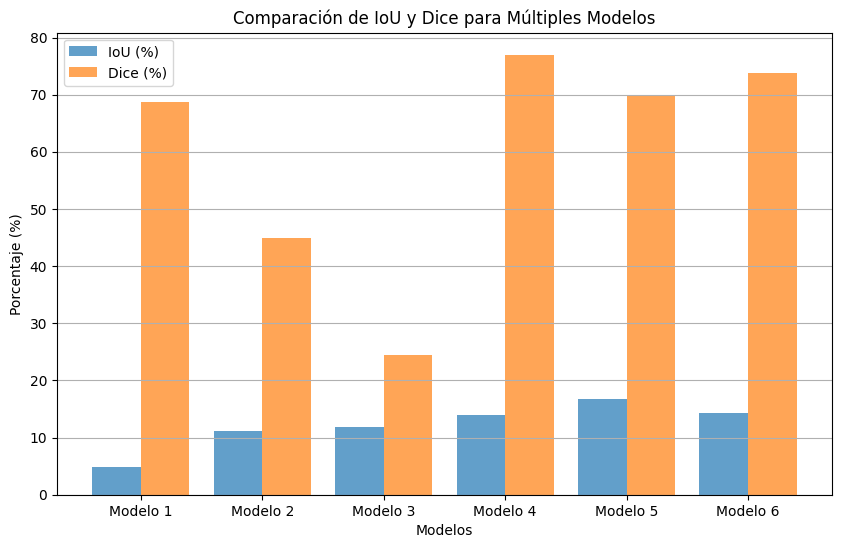

In [13]:
import matplotlib.pyplot as plt

def compare_iou_dice(models, test_loader, threshold=0.5, device=DEVICE):
    """
    Compara gráficamente el rendimiento de múltiples modelos en términos de IoU y Dice usando un único umbral.

    Args:
        models (list): Lista de modelos entrenados.
        test_loader (DataLoader): DataLoader con las imágenes y etiquetas del conjunto de prueba.
        threshold (float): Umbral para binarizar las predicciones.
        device (torch.device): Dispositivo en el que se ejecutarán los modelos.
    """
    iou_scores = []
    dice_scores = []
    model_names = [f"Modelo {i+1}" for i in range(len(models))]

    for i, model in enumerate(models):
        model.eval()
        model.to(device)

        iou_list = []
        dice_list = []

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = torch.sigmoid(model(images))

                # Calcular IoU y Dice
                metrics = calculate_metrics(labels, outputs, threshold)
                iou_list.append(metrics["IoU (%)"])
                dice_list.append(calculate_dice(labels, outputs, threshold) * 100)  # Convertimos Dice a porcentaje

        # Promediar las métricas para el modelo actual
        iou_scores.append(np.mean(iou_list))
        dice_scores.append(np.mean(dice_list))

    # Crear gráfico comparativo
    x = range(len(models))
    width = 0.4

    plt.figure(figsize=(10, 6))
    plt.bar(x, iou_scores, width=width, label="IoU (%)", alpha=0.7)
    plt.bar([p + width for p in x], dice_scores, width=width, label="Dice (%)", alpha=0.7)

    plt.title("Comparación de IoU y Dice para Múltiples Modelos")
    plt.xlabel("Modelos")
    plt.ylabel("Porcentaje (%)")
    plt.xticks([p + width / 2 for p in x], model_names)
    plt.legend()
    plt.grid(axis='y')
    plt.show()

# Ejemplo de uso
compare_iou_dice(models, val_loader, threshold=0.5)


In [8]:
best_model_path=r"C:\Users\jerij\Carpetas\Clases Formaciones Curro\Master\2Semestre\Proyecto\best_model2_dataaugmented_fullhd.pt"
model=load_model(UNet,best_model_path)

C:\Users\jerij\AppData\Local\Temp\ipykernel_1412\2838457259.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_locati

In [9]:
root_dir = r"C:\Users\jerij\Carpetas\Clases Formaciones Curro\Master\2Semestre\Proyecto\Data\Pruebas"  
images, labels, images_augmented, labels_augmented = load_dataset(root_dir)
print(f"Número de imágenes cargadas: {len(images)}")
print(f"Número de etiquetas cargadas: {len(labels)}")
print(f"Número de imágenes augmented cargadas: {len(images_augmented)}")
print(f"Número de etiquetas augmented cargadas: {len(labels_augmented)}")
images = [img / 255.0 for img in images]
labels = [label / 255.0 for label in labels]
dataset_evaluacion = CustomDataset(images, labels, transform, label_transform)
evaluacion_loader = DataLoader(dataset_evaluacion, batch_size=1, shuffle=True)

Número de imágenes cargadas: 16
Número de etiquetas cargadas: 16
Número de imágenes augmented cargadas: 0
Número de etiquetas augmented cargadas: 0


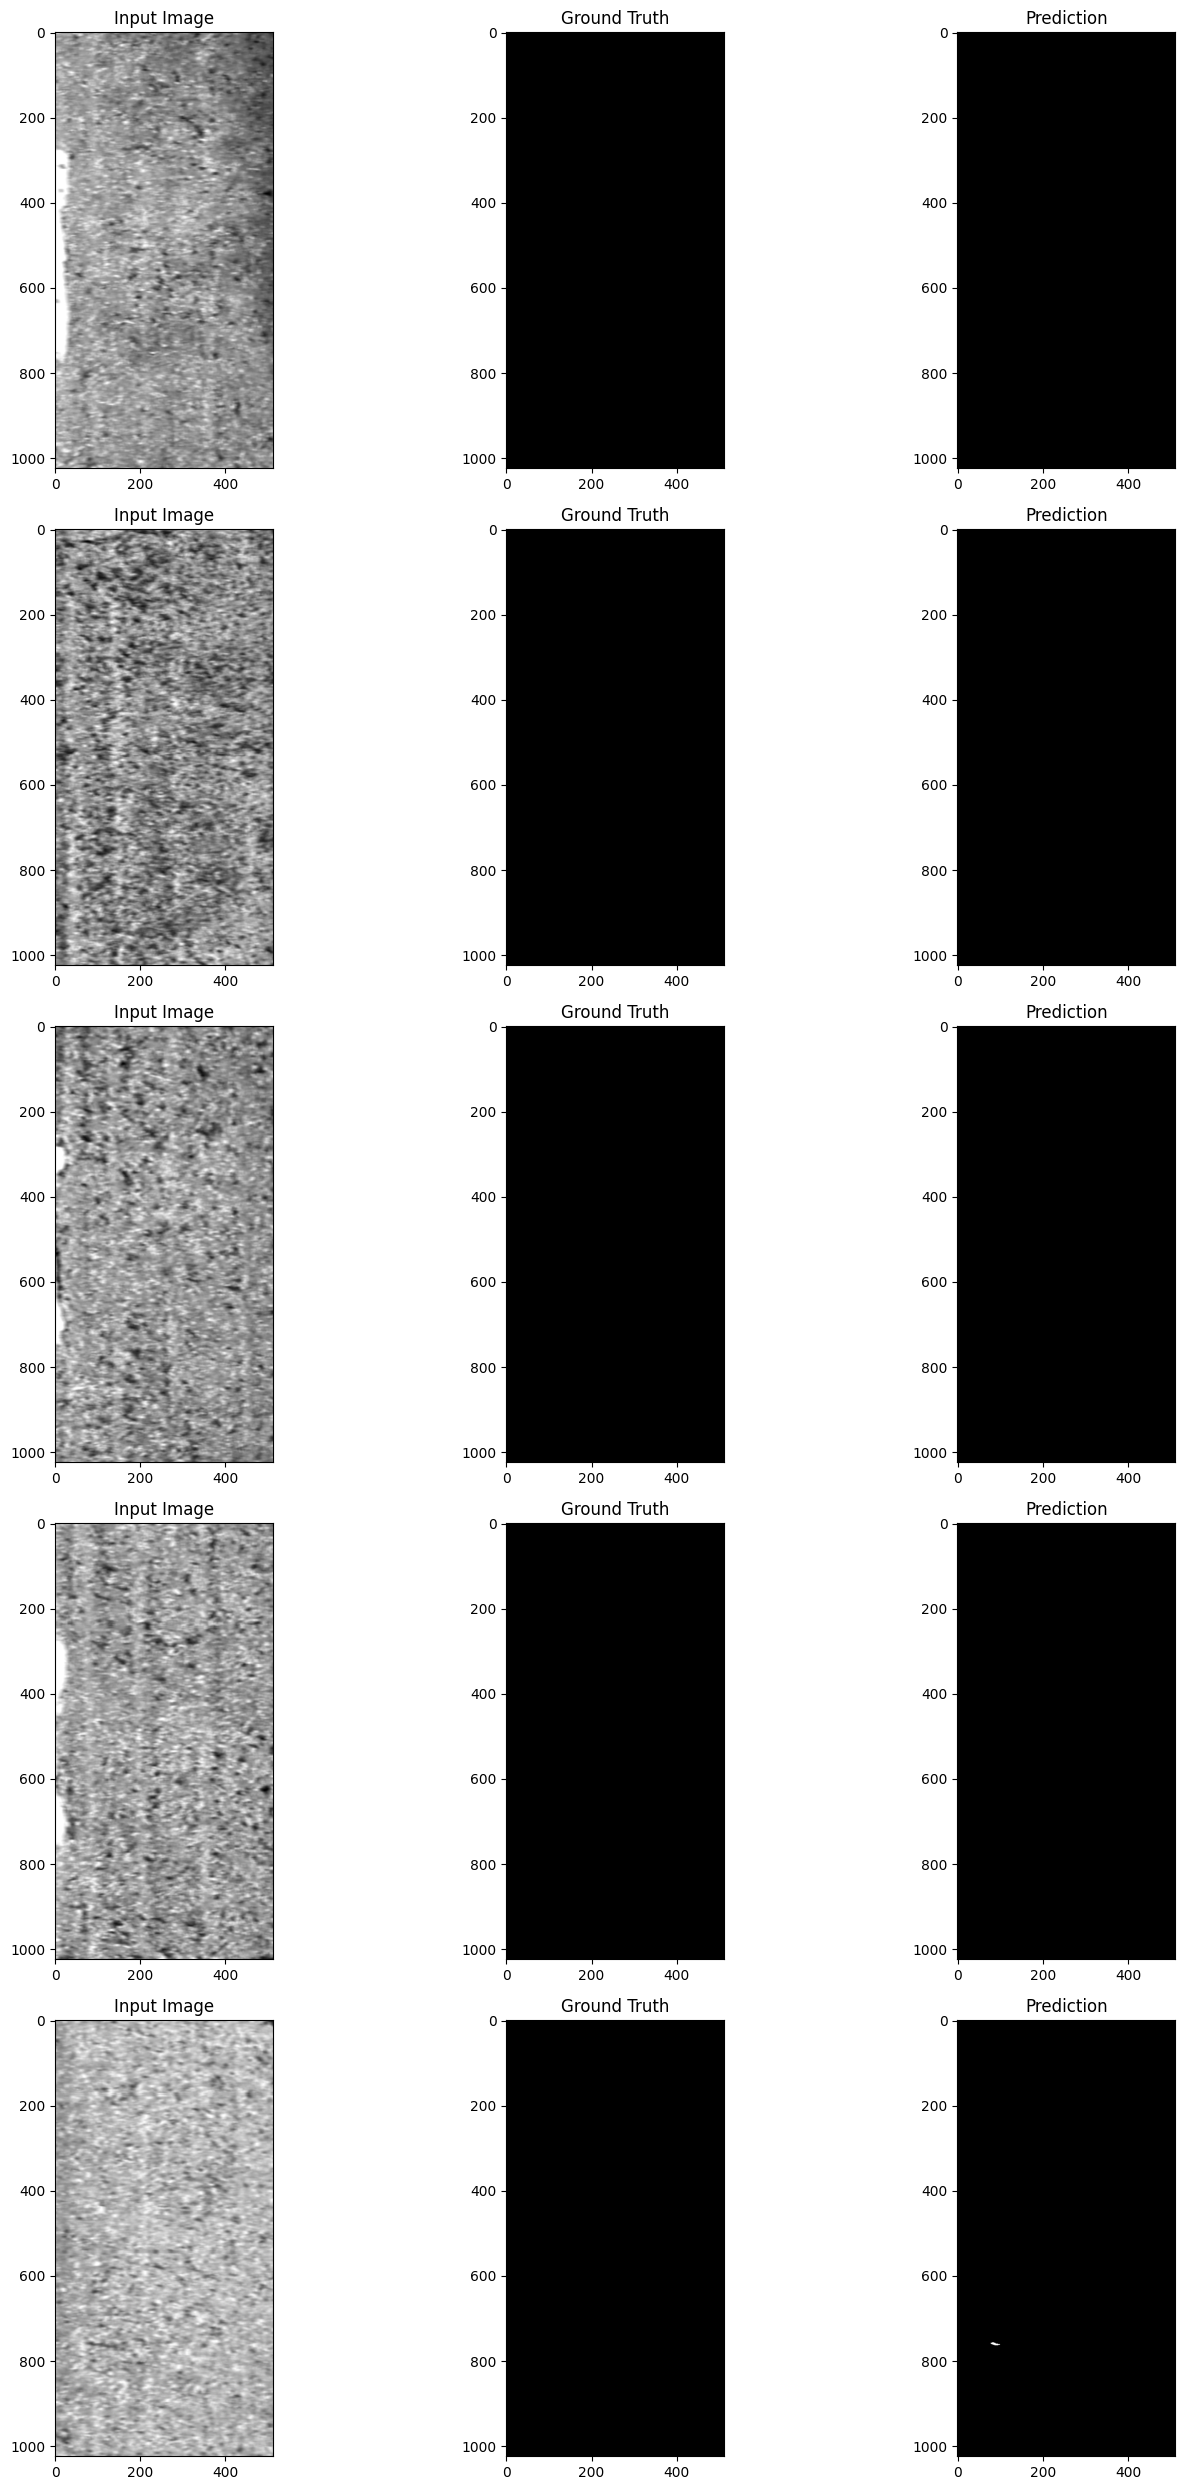

In [10]:
visualize_predictions(model, test_loader, num_samples=5, threshold=0.70)

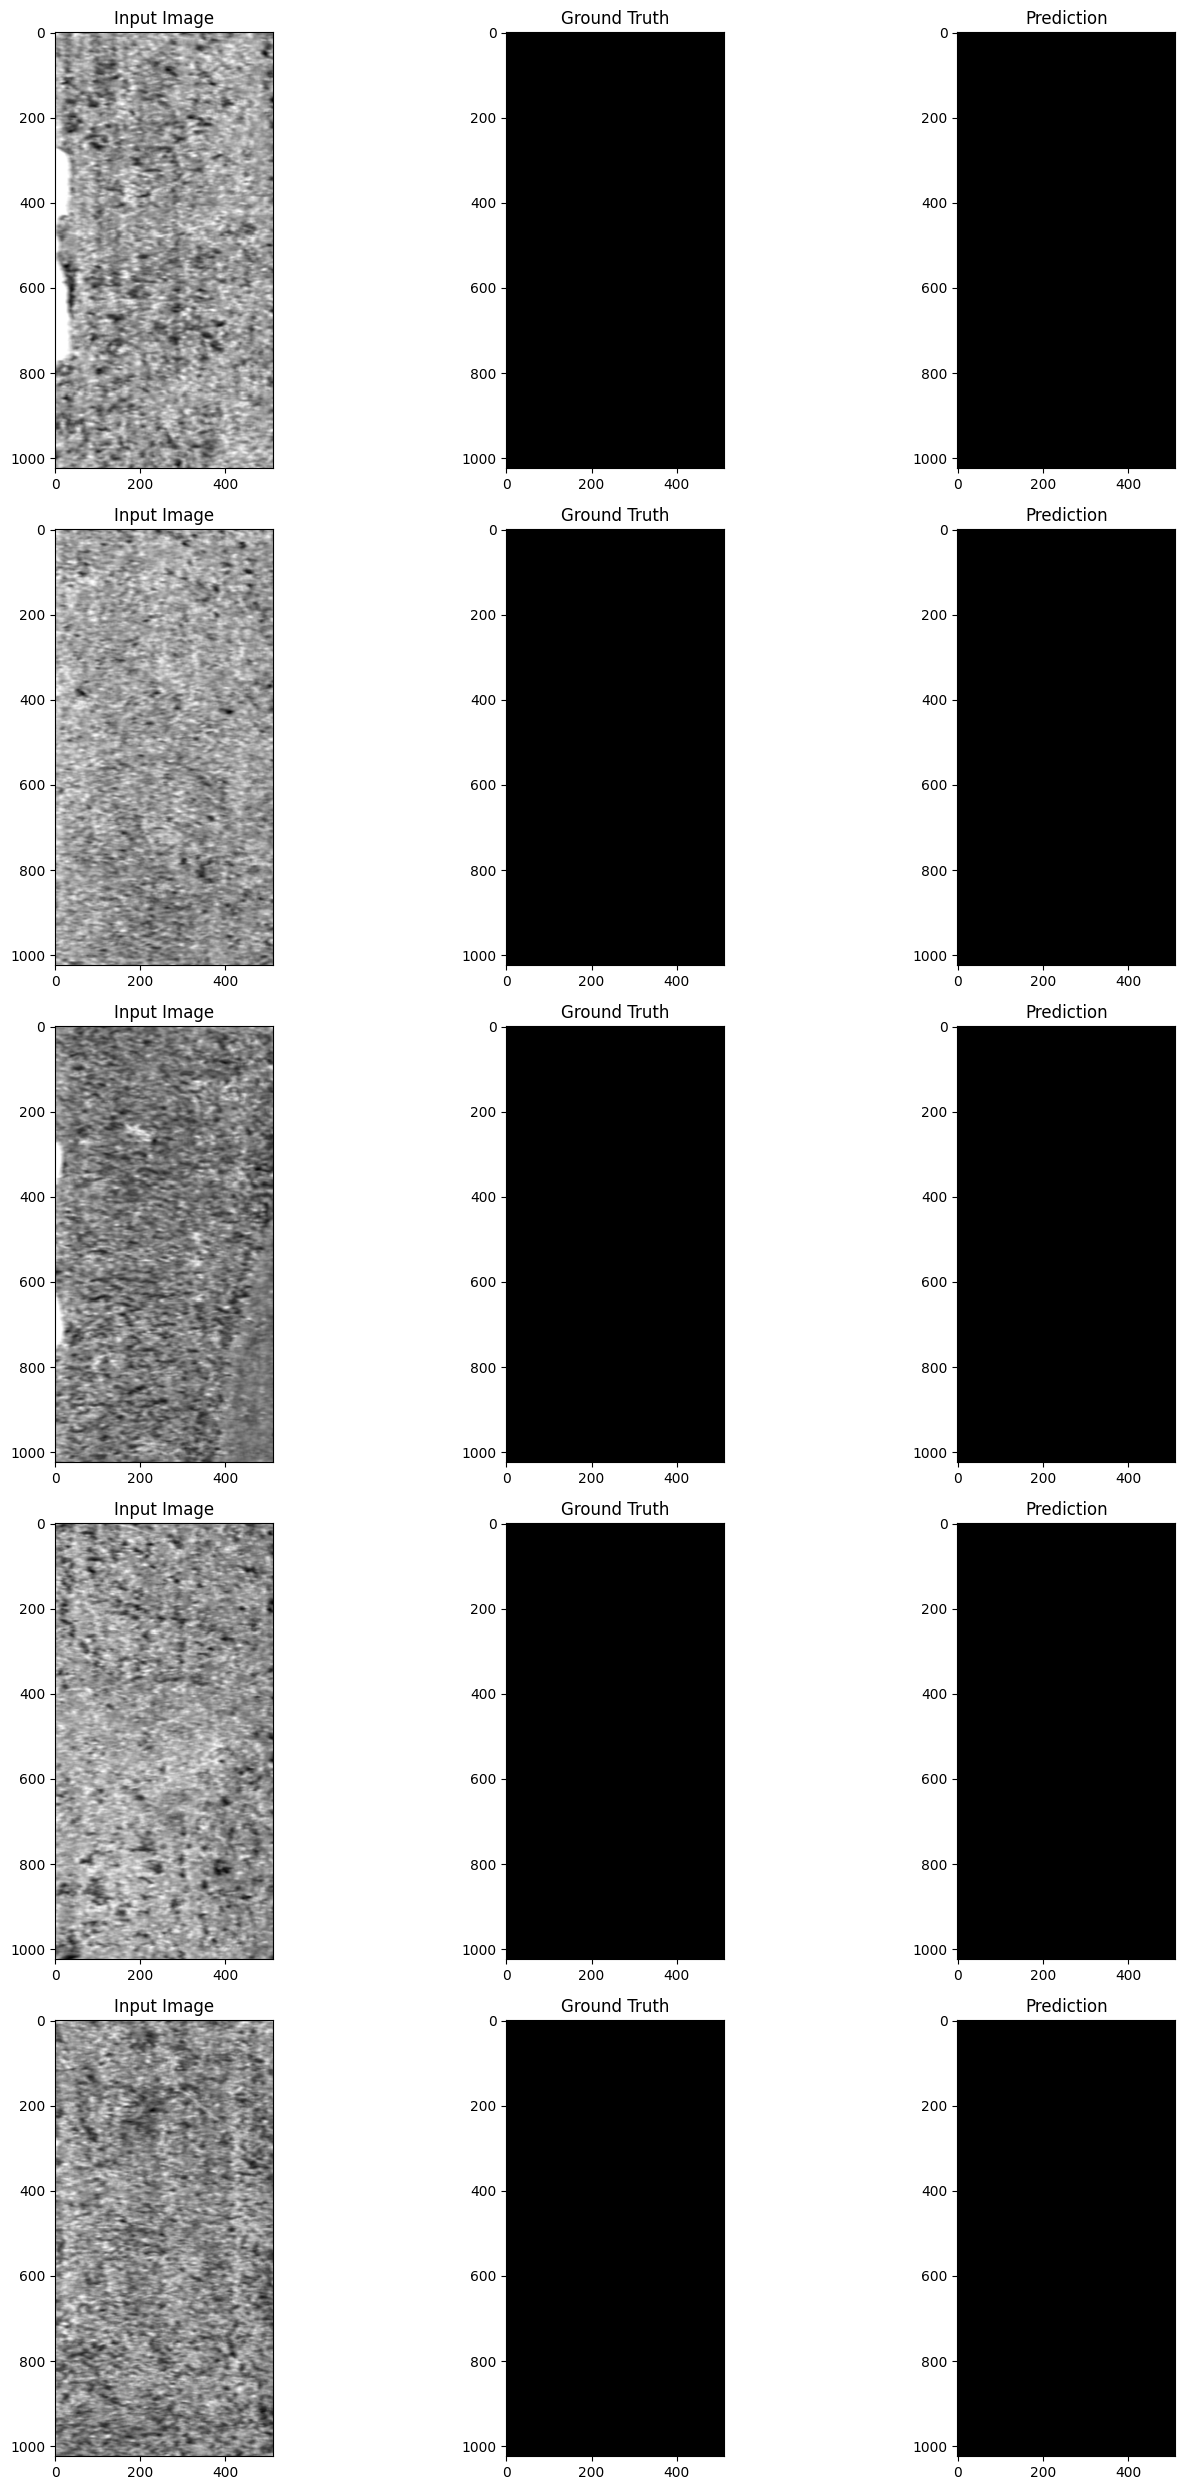

In [11]:
visualize_predictions(model, test_loader, num_samples=5, threshold=0.70)

IndexError: index 10 is out of bounds for axis 0 with size 10

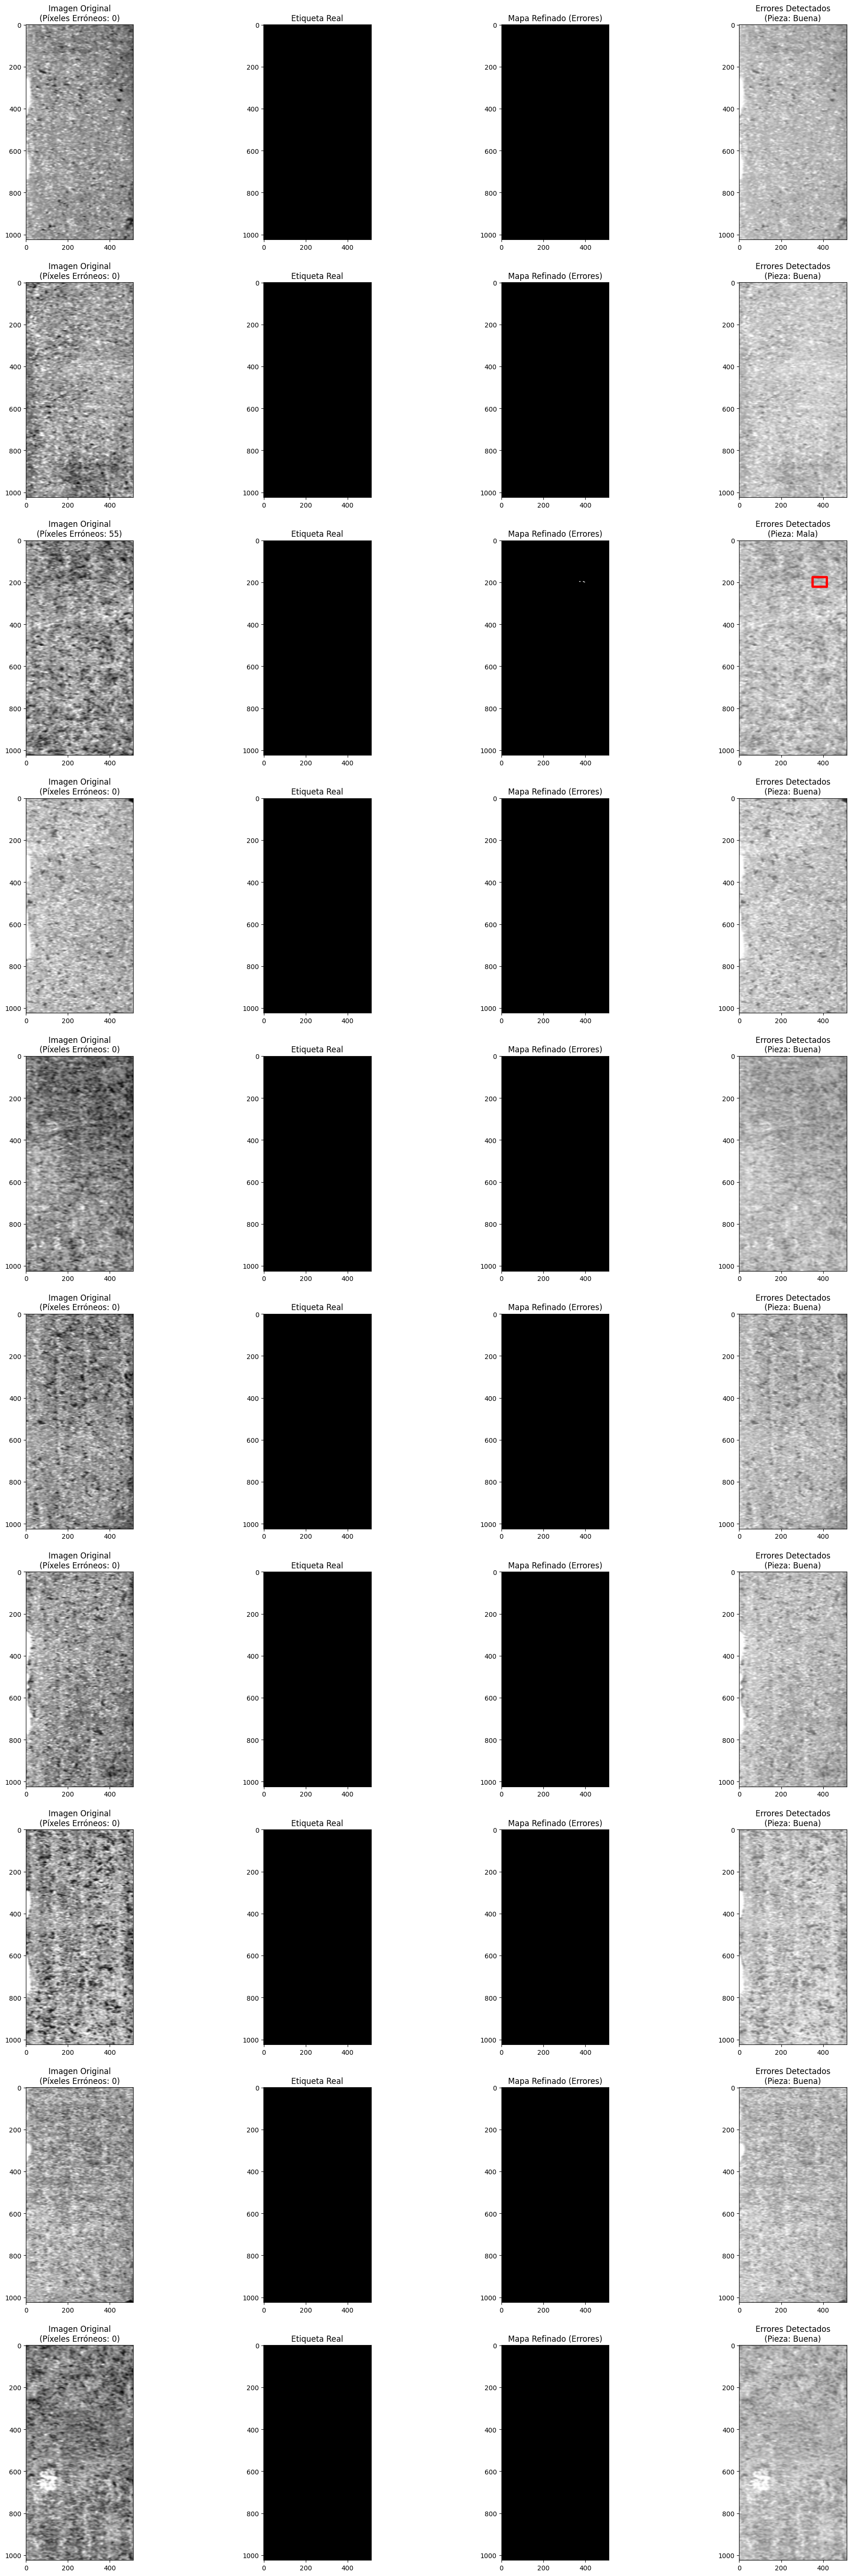

In [12]:
filter_and_visualize_errors_from_bitmap_post(
    model=model,
    data_loader=val_loader,
    pixel_threshold=50,
    pred_threshold=0.60,
    kernel_size=3,
    num_bad_samples=5
)